In [1]:
# Group 7 - Noah L. Schrick

In [2]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from dmba import regressionSummary
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression
from sklearn.datasets import make_hastie_10_2
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report,confusion_matrix
from sklearn import preprocessing


In [3]:
# Import data
timing_df = pd.read_csv('timing.csv')

# Exploratory Analysis

## Parallel Coordinates Plot

In [4]:
import plotly.express as px
overall_df = timing_df[['nodes', 'exploit', 'appl', 'load', 'runtime']]
overall_df['load'] = overall_df['load'].replace(395,0)
overall_df['load'] = overall_df['load'].replace(296,25)
overall_df['load'] = overall_df['load'].replace(197,50)
overall_df['load'] = overall_df['load'].replace(79,75)
overall_df['load'] = overall_df['load'].replace(1,100)

# , [296,25], [197,50], [79,75], [1,100]
fig = px.parallel_coordinates(overall_df, color="runtime", labels={"runtime": "runtime",
                "nodes": "nodes", "exploit": "exploit",
                "appl": "appl", "load": "load", },
                             color_continuous_scale=px.colors.diverging.Tealrose,
                             color_continuous_midpoint=2)
fig.show()

/tmp/ipykernel_12892/509936392.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  overall_df['load'] = overall_df['load'].replace(395,0)
/tmp/ipykernel_12892/509936392.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  overall_df['load'] = overall_df['load'].replace(296,25)
/tmp/ipykernel_12892/509936392.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pan

## VIF

In [5]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
predictors = ['nodes', 'exploit', 'appl', 'load']
X = timing_df[predictors]

# VIF dataframe
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
  
# calculating VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(X.values, i)
                          for i in range(len(X.columns))]
  
print(vif_data)


   feature       VIF
0    nodes  4.095428
1  exploit  1.102242
2     appl  2.481514
3     load  5.401378


## Plot raw features with outcome

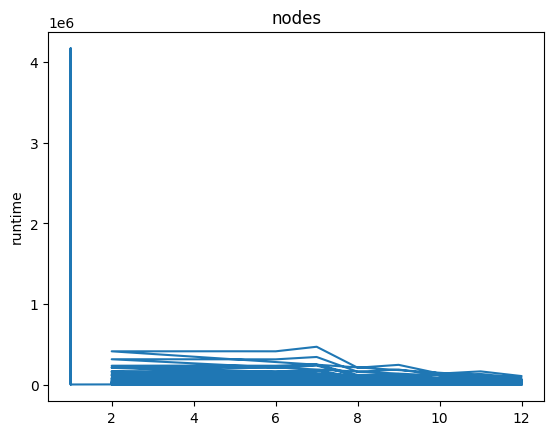

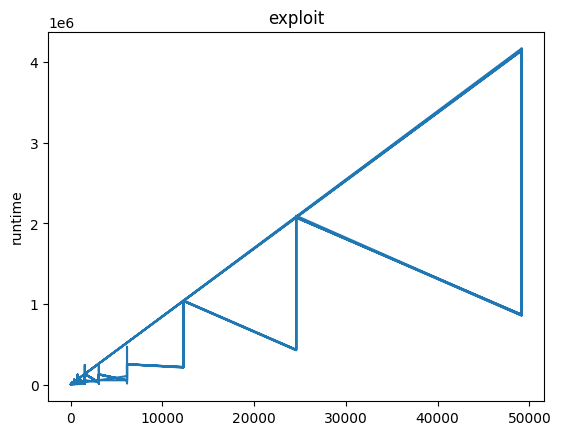

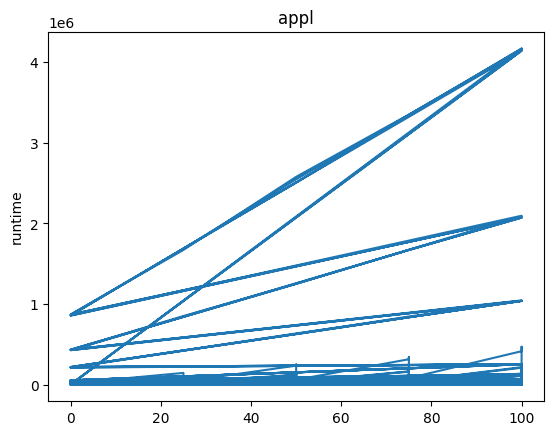

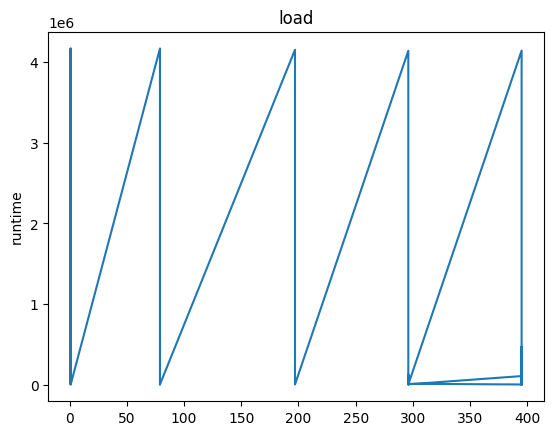

In [6]:
for feat in ['nodes', 'exploit', 'appl', 'load']:
    plt.figure()
    plt.plot(timing_df[feat], timing_df['runtime'])
    plt.title(feat)
    plt.ylabel('runtime')

## Show avg timing data for each var step (EX: Avg time for 12 nodes, 11...1, Avg time for 6 exploits...49152)


/tmp/ipykernel_12892/3831858898.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_12892/3831858898.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_12892/3831858898.py:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_1

<AxesSubplot: title={'center': 'Database Load vs Runtime'}, xlabel='Database Load (%)', ylabel='Runtime (ms)'>

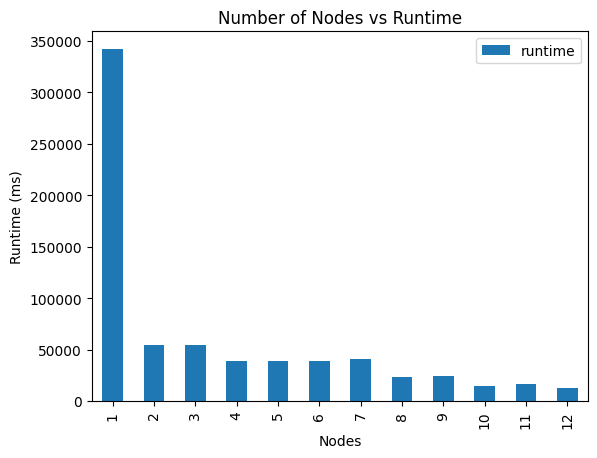

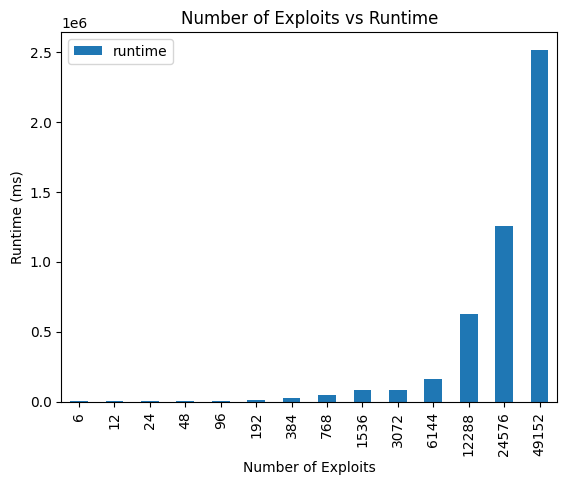

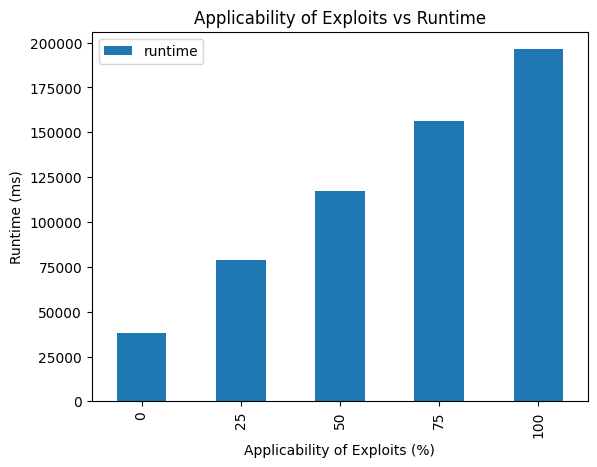

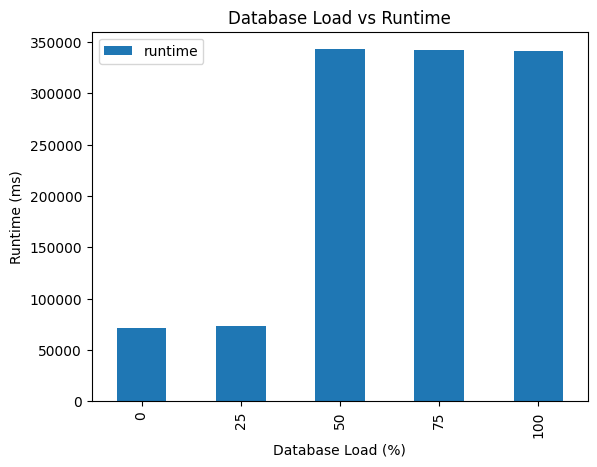

In [7]:
node_pivot = timing_df.pivot_table(index=["nodes"], values=["runtime"], aggfunc='mean')
exploit_pivot = timing_df.pivot_table(index=["exploit"], values=["runtime"], aggfunc='mean')
appl_pivot = timing_df.pivot_table(index=["appl"], values=["runtime"], aggfunc='mean')

overall_df['load'] = overall_df['load'].replace(395,0)
overall_df['load'] = overall_df['load'].replace(296,25)
overall_df['load'] = overall_df['load'].replace(197,50)
overall_df['load'] = overall_df['load'].replace(79,75)
overall_df['load'] = overall_df['load'].replace(1,100)
load_pivot = overall_df.pivot_table(index=["load"], values=["runtime"], aggfunc='mean')

node_pivot.plot(kind='bar', title='Number of Nodes vs Runtime', ylabel='Runtime (ms)', xlabel="Nodes")
exploit_pivot.plot(kind='bar', title='Number of Exploits vs Runtime', ylabel='Runtime (ms)', xlabel="Number of Exploits")
appl_pivot.plot(kind='bar', title='Applicability of Exploits vs Runtime', ylabel='Runtime (ms)', xlabel="Applicability of Exploits (%)")
load_pivot.plot(kind='bar', title='Database Load vs Runtime', ylabel='Runtime (ms)', xlabel="Database Load (%)")


## Correlation and Matrix Plot

<AxesSubplot: >

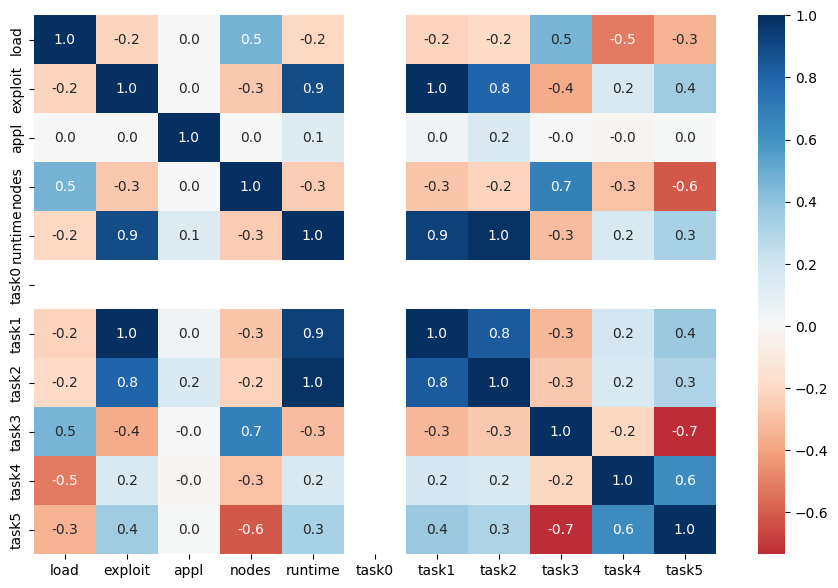

In [7]:
timing_corr = timing_df.corr().round(3)
# print(timing_corr)
fig, ax = plt.subplots()
fig.set_size_inches(11, 7)
sns.heatmap(timing_corr, annot=True, fmt=".1f", cmap="RdBu", center=0, ax=ax)

# Speedup and Efficiency

In [8]:
# Add speedup and efficiency columns
timing_df['speedup'] = np.nan
timing_df['efficiency'] = np.nan
for idx, row in timing_df.iterrows():
    nodes,exploits,appl,load = row['nodes'], row['exploit'], row['appl'], row['load']
    timing_df.at[idx,'speedup'] = timing_df['runtime'][timing_df['nodes'] == 1][timing_df['exploit']==exploits][timing_df['appl']==appl][timing_df['load']==load].values[0]/timing_df['runtime'][timing_df['nodes'] == nodes][timing_df['exploit']==exploits][timing_df['appl']==appl][timing_df['load']==load].values[0]
    timing_df.at[idx,'efficiency'] = timing_df['runtime'][timing_df['nodes'] == 1][timing_df['exploit']==exploits][timing_df['appl']==appl][timing_df['load']==load].values[0]/(timing_df['runtime'][timing_df['nodes'] == nodes][timing_df['exploit']==exploits][timing_df['appl']==appl][timing_df['load']==load].values[0]*nodes)

## Min, Max, Mean: Nodes

/tmp/ipykernel_12892/1772356950.py:2: FutureWarning:

DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead



<AxesSubplot: title={'center': 'Minimum, Maximum, and Mean Speedups of MPI Tasking\n for Increasing Problem Sizes'}, xlabel='Number of Nodes', ylabel="Speedup (Amdahl's)">

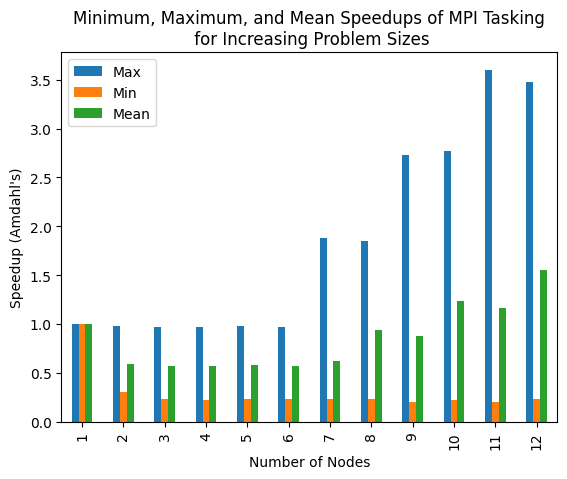

In [9]:
res_spd_df = pd.DataFrame(timing_df.pivot_table(index=["nodes"], values=["speedup"], aggfunc=['max', 'min', 'mean']).to_records())
res_spd_df.set_axis(['Nodes', 'Max', 'Min', 'Mean'], axis=1, inplace=True)
res_spd_df.plot(kind='bar', x='Nodes', title='Minimum, Maximum, and Mean Speedups of MPI Tasking\n for Increasing Problem Sizes', ylabel="Speedup (Amdahl's)", xlabel="Number of Nodes")

/tmp/ipykernel_12892/2421668426.py:2: FutureWarning:

DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead



<AxesSubplot: title={'center': 'Minimum, Maximum, and Mean Efficiencies of MPI Tasking\n for Increasing Problem Sizes'}, xlabel='Number of Nodes', ylabel='Efficiency'>

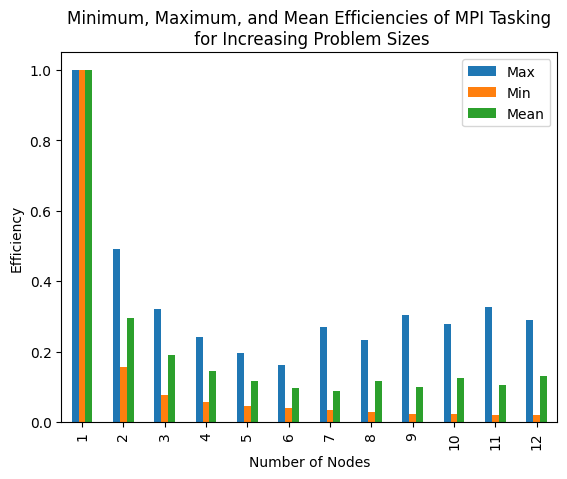

In [10]:
res_eff_df = pd.DataFrame(timing_df.pivot_table(index=["nodes"], values=["efficiency"], aggfunc=['max', 'min', 'mean']).to_records())
res_eff_df.set_axis(['Nodes', 'Max', 'Min', 'Mean'], axis=1, inplace=True)
res_eff_df.plot(kind='bar', x='Nodes', title='Minimum, Maximum, and Mean Efficiencies of MPI Tasking\n for Increasing Problem Sizes', ylabel="Efficiency", xlabel="Number of Nodes")

## Exploits, Appl, Nodes

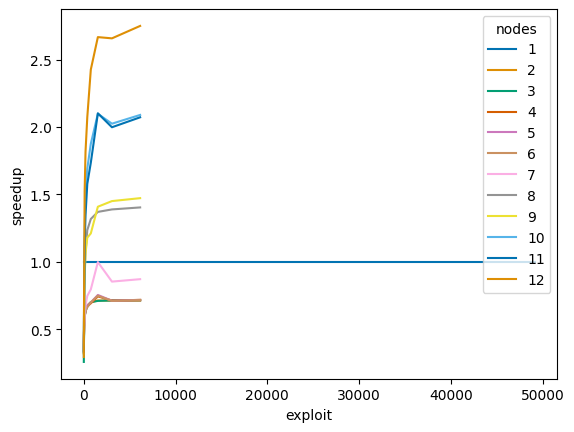

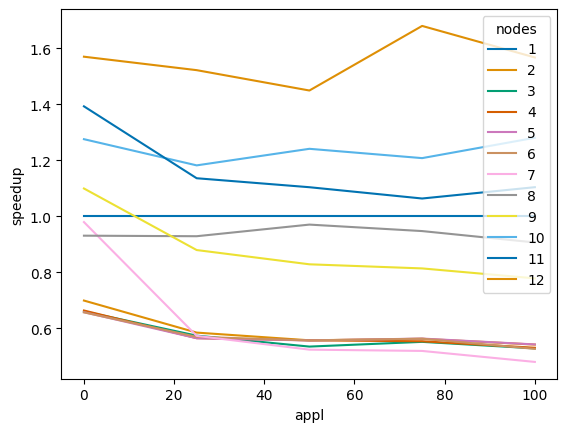

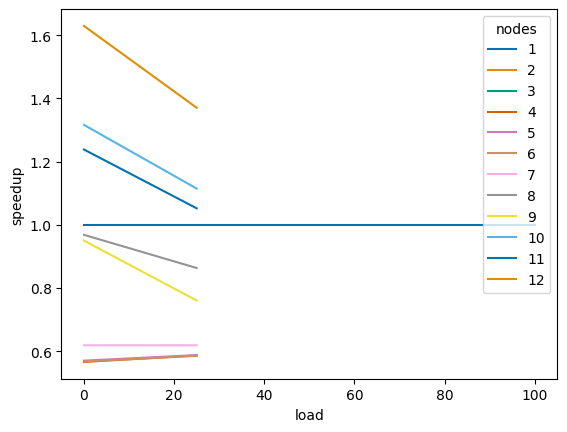

In [11]:
# x axis: exploits
# y axis: speedup and eff
# At each xtick: compartments 0-100 for appl. Min, mean, max for each?
tmp_pv = pd.DataFrame(timing_df.pivot_table(index=["exploit", "nodes"], values=["speedup"], aggfunc='mean').to_records())
ax = sns.lineplot(x="exploit", y="speedup", hue="nodes", palette="colorblind", data=tmp_pv)
plt.show()

tmp_pv = pd.DataFrame(timing_df.pivot_table(index=["appl", "nodes"], values=["speedup"], aggfunc='mean').to_records())
ax = sns.lineplot(x="appl", y="speedup", hue="nodes", palette="colorblind", data=tmp_pv)
plt.show()

tmp_pv = pd.DataFrame(timing_df.pivot_table(index=["load", "nodes"], values=["speedup"], aggfunc='mean').to_records())
tmp_pv['load'] = tmp_pv['load'].replace(395,0)
tmp_pv['load'] = tmp_pv['load'].replace(296,25)
tmp_pv['load'] = tmp_pv['load'].replace(197,50)
tmp_pv['load'] = tmp_pv['load'].replace(79,75)
tmp_pv['load'] = tmp_pv['load'].replace(1,100)
ax = sns.lineplot(x="load", y="speedup", hue="nodes", palette="colorblind", data=tmp_pv)
plt.show()

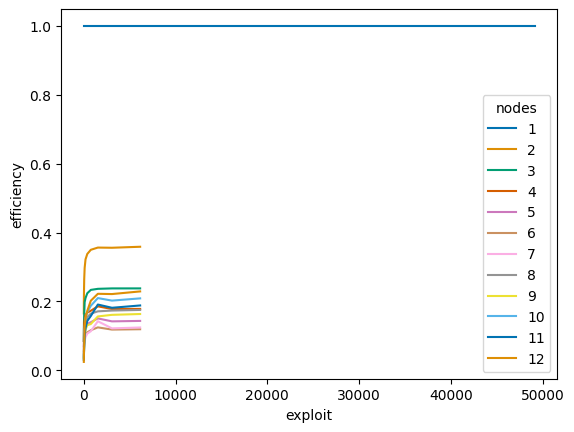

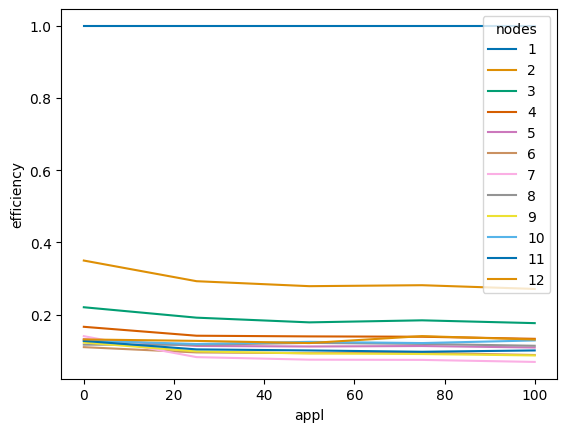

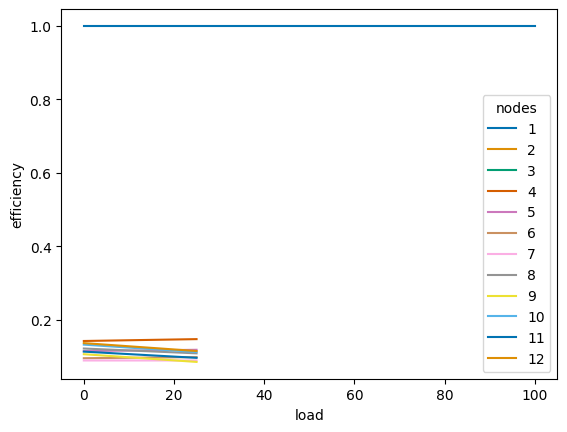

In [13]:
# x axis: exploits
# y axis: speedup and eff
# At each xtick: compartments 0-100 for appl. Min, mean, max for each?
tmp_pv = pd.DataFrame(timing_df.pivot_table(index=["exploit", "nodes"], values=["efficiency"], aggfunc='mean').to_records())
ax = sns.lineplot(x="exploit", y="efficiency", hue="nodes", palette="colorblind", data=tmp_pv)
plt.show()

tmp_pv = pd.DataFrame(timing_df.pivot_table(index=["appl", "nodes"], values=["efficiency"], aggfunc='mean').to_records())
ax = sns.lineplot(x="appl", y="efficiency", hue="nodes", palette="colorblind", data=tmp_pv)
plt.show()

tmp_pv = pd.DataFrame(timing_df.pivot_table(index=["load", "nodes"], values=["efficiency"], aggfunc='mean').to_records())
tmp_pv['load'] = tmp_pv['load'].replace(395,0)
tmp_pv['load'] = tmp_pv['load'].replace(296,25)
tmp_pv['load'] = tmp_pv['load'].replace(197,50)
tmp_pv['load'] = tmp_pv['load'].replace(79,75)
tmp_pv['load'] = tmp_pv['load'].replace(1,100)
ax = sns.lineplot(x="load", y="efficiency", hue="nodes", palette="colorblind", data=tmp_pv)
plt.show()

# Linear Regression

## Indiv Vars
### Linear Regression - Overall Runtime
#### Nodes

In [5]:
predictors = ['nodes']
overall_outcome = 'runtime'

# partition data
X = timing_df[predictors]
overall_y = timing_df[overall_outcome]
train_X, valid_X, train_y, valid_y = train_test_split(X, overall_y, test_size=0.4, random_state=1)
runtime_lm = LinearRegression()
runtime_lm.fit(train_X, train_y)
# print coefficients
print('intercept ', runtime_lm.intercept_)
print(pd.DataFrame({'Predictor': X.columns, 'coefficient': runtime_lm.coef_}))
# print performance measures
regressionSummary(train_y, runtime_lm.predict(train_X))

intercept  303728.87235091545
  Predictor   coefficient
0     nodes -32534.157117

Regression statistics

                      Mean Error (ME) : -0.0000
       Root Mean Squared Error (RMSE) : 442361.0172
            Mean Absolute Error (MAE) : 198916.6752
          Mean Percentage Error (MPE) : -3076.0279
Mean Absolute Percentage Error (MAPE) : 3664.0029


In [74]:
scaler = preprocessing.MinMaxScaler()
d = scaler.fit_transform(timing_df)
normalized_df = pd.DataFrame(d, columns=timing_df.columns)

predictors = ['nodes']
overall_outcome = 'runtime'

# partition data
X = normalized_df[predictors]
overall_y = normalized_df[overall_outcome]
train_X, valid_X, train_y, valid_y = train_test_split(X, overall_y, test_size=0.4, random_state=1)
runtime_lm = LinearRegression()
runtime_lm.fit(train_X, train_y)
# print coefficients
print('intercept ', runtime_lm.intercept_)
print(pd.DataFrame({'Predictor': X.columns, 'coefficient': runtime_lm.coef_}))
# print performance measures
regressionSummary(train_y, runtime_lm.predict(train_X))


intercept  0.06488133316235689
  Predictor  coefficient
0     nodes    -0.085788

Regression statistics

                      Mean Error (ME) : 0.0000
       Root Mean Squared Error (RMSE) : 0.1060
            Mean Absolute Error (MAE) : 0.0477
          Mean Percentage Error (MPE) : -32832.1198
Mean Absolute Percentage Error (MAPE) : 33548.5134


#### Exploit

In [6]:
predictors = ['exploit']
overall_outcome = 'runtime'

# partition data
X = timing_df[predictors]
overall_y = timing_df[overall_outcome]
train_X, valid_X, train_y, valid_y = train_test_split(X, overall_y, test_size=0.4, random_state=1)
runtime_lm = LinearRegression()
runtime_lm.fit(train_X, train_y)
# print coefficients
print('intercept ', runtime_lm.intercept_)
print(pd.DataFrame({'Predictor': X.columns, 'coefficient': runtime_lm.coef_}))
# print performance measures
regressionSummary(train_y, runtime_lm.predict(train_X))

intercept  -8788.042556187662
  Predictor  coefficient
0   exploit    50.283347

Regression statistics

                      Mean Error (ME) : -0.0000
       Root Mean Squared Error (RMSE) : 197437.6040
            Mean Absolute Error (MAE) : 62749.3897
          Mean Percentage Error (MPE) : 180.5994
Mean Absolute Percentage Error (MAPE) : 275.3917


#### Appl

intercept  42450.91771345622
  Predictor  coefficient
0      appl  1748.317923

Regression statistics

                      Mean Error (ME) : -0.0000
       Root Mean Squared Error (RMSE) : 454831.8590
            Mean Absolute Error (MAE) : 186480.9214
          Mean Percentage Error (MPE) : -2691.9685
Mean Absolute Percentage Error (MAPE) : 2705.9283


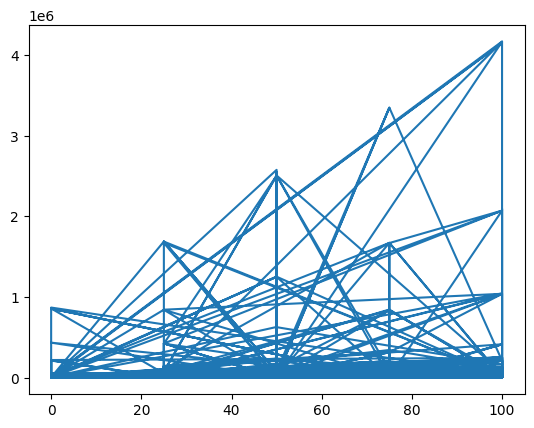

In [60]:
predictors = ['appl']
overall_outcome = 'runtime'

# partition data
X = timing_df[predictors]
overall_y = timing_df[overall_outcome]
train_X, valid_X, train_y, valid_y = train_test_split(X, overall_y, test_size=0.4, random_state=1)
runtime_lm = LinearRegression()
runtime_lm.fit(train_X, train_y)
# print coefficients
print('intercept ', runtime_lm.intercept_)
print(pd.DataFrame({'Predictor': X.columns, 'coefficient': runtime_lm.coef_}))
# print performance measures
regressionSummary(train_y, runtime_lm.predict(train_X))

In [75]:
scaler = preprocessing.MinMaxScaler()
d = scaler.fit_transform(timing_df)
normalized_df = pd.DataFrame(d, columns=timing_df.columns)

predictors = ['appl']
overall_outcome = 'runtime'

# partition data
X = normalized_df[predictors]
overall_y = normalized_df[overall_outcome]
train_X, valid_X, train_y, valid_y = train_test_split(X, overall_y, test_size=0.4, random_state=1)
runtime_lm = LinearRegression()
runtime_lm.fit(train_X, train_y)
# print coefficients
print('intercept ', runtime_lm.intercept_)
print(pd.DataFrame({'Predictor': X.columns, 'coefficient': runtime_lm.coef_}))
# print performance measures
regressionSummary(train_y, runtime_lm.predict(train_X))

intercept  0.010048066606673962
  Predictor  coefficient
0      appl      0.04191

Regression statistics

                      Mean Error (ME) : 0.0000
       Root Mean Squared Error (RMSE) : 0.1090
            Mean Absolute Error (MAE) : 0.0447
          Mean Percentage Error (MPE) : -17606.2312
Mean Absolute Percentage Error (MAPE) : 17620.2063


#### Load

In [8]:
predictors = ['load']
overall_outcome = 'runtime'

# partition data
X = timing_df[predictors]
overall_y = timing_df[overall_outcome]
train_X, valid_X, train_y, valid_y = train_test_split(X, overall_y, test_size=0.4, random_state=1)
runtime_lm = LinearRegression()
runtime_lm.fit(train_X, train_y)
# print coefficients
print('intercept ', runtime_lm.intercept_)
print(pd.DataFrame({'Predictor': X.columns, 'coefficient': runtime_lm.coef_}))
# print performance measures
regressionSummary(train_y, runtime_lm.predict(train_X))

intercept  445536.13965568773
  Predictor  coefficient
0      load -1015.396933

Regression statistics

                      Mean Error (ME) : -0.0000
       Root Mean Squared Error (RMSE) : 442633.9662
            Mean Absolute Error (MAE) : 186136.1892
          Mean Percentage Error (MPE) : -3308.5538
Mean Absolute Percentage Error (MAPE) : 3331.5614


## All Vars

### Linear Regression - Overall Runtime

In [9]:
predictors = ['nodes', 'exploit', 'appl', 'load']
overall_outcome = 'runtime'

# partition data
X = timing_df[predictors]
overall_y = timing_df[overall_outcome]
train_X, valid_X, train_y, valid_y = train_test_split(X, overall_y, test_size=0.4, random_state=1)
runtime_lm = LinearRegression()
runtime_lm.fit(train_X, train_y)
# print coefficients
print('intercept ', runtime_lm.intercept_)
print(pd.DataFrame({'Predictor': X.columns, 'coefficient': runtime_lm.coef_}))
# print performance measures
regressionSummary(train_y, runtime_lm.predict(train_X))

intercept  -58054.89252320345
  Predictor  coefficient
0     nodes  -872.584718
1   exploit    49.805953
2      appl  1575.244214
3      load   -68.075156

Regression statistics

                      Mean Error (ME) : 0.0000
       Root Mean Squared Error (RMSE) : 189043.5348
            Mean Absolute Error (MAE) : 82436.8687
          Mean Percentage Error (MPE) : 334.3634
Mean Absolute Percentage Error (MAPE) : 1191.8060


### Linear Regression - Task 0

In [10]:
# Linear Regression - Task 0
t0_outcome = 'task0'

# partition data
X = timing_df[predictors]
overall_y = timing_df[t0_outcome]
train_X, valid_X, train_y, valid_y = train_test_split(X, overall_y, test_size=0.4, random_state=1)
t0_lm = LinearRegression()
t0_lm.fit(train_X, train_y)
# print coefficients
print('intercept ', t0_lm.intercept_)
print(pd.DataFrame({'Predictor': X.columns, 'coefficient': t0_lm.coef_}))
# print performance measures
regressionSummary(train_y, t0_lm.predict(train_X))

intercept  0.0
  Predictor  coefficient
0     nodes          0.0
1   exploit          0.0
2      appl          0.0
3      load          0.0

Regression statistics

               Mean Error (ME) : 0.0000
Root Mean Squared Error (RMSE) : 0.0000
     Mean Absolute Error (MAE) : 0.0000


### Linear Regression - Task 1

In [11]:
# Linear Regression - Task 1
t1_outcome = 'task1'

# partition data
X = timing_df[predictors]
overall_y = timing_df[t1_outcome]
train_X, valid_X, train_y, valid_y = train_test_split(X, overall_y, test_size=0.4, random_state=1)
t1_lm = LinearRegression()
t1_lm.fit(train_X, train_y)
# print coefficients
print('intercept ', t1_lm.intercept_)
print(pd.DataFrame({'Predictor': X.columns, 'coefficient': t1_lm.coef_}))
# print performance measures
regressionSummary(train_y, t1_lm.predict(train_X))

intercept  -8930.11863104882
  Predictor  coefficient
0     nodes  -232.287083
1   exploit    18.859014
2      appl   151.902207
3      load    -7.775745

Regression statistics

                      Mean Error (ME) : -0.0000
       Root Mean Squared Error (RMSE) : 19547.1452
            Mean Absolute Error (MAE) : 11878.2487
          Mean Percentage Error (MPE) : 766.9344
Mean Absolute Percentage Error (MAPE) : 912.9252


### Linear Regression - Task 2

In [12]:
# Linear Regression - Task 2
t2_outcome = 'task2'

# partition data
X = timing_df[predictors]
overall_y = timing_df[t2_outcome]
train_X, valid_X, train_y, valid_y = train_test_split(X, overall_y, test_size=0.4, random_state=1)
t2_lm = LinearRegression()
t2_lm.fit(train_X, train_y)
# print coefficients
print('intercept ', t2_lm.intercept_)
print(pd.DataFrame({'Predictor': X.columns, 'coefficient': t2_lm.coef_}))
# print performance measures
regressionSummary(train_y, t2_lm.predict(train_X))

intercept  -33033.61791812297
  Predictor  coefficient
0     nodes    98.141525
1   exploit    28.211256
2      appl  1191.485769
3      load  -114.265223

Regression statistics

                      Mean Error (ME) : 0.0000
       Root Mean Squared Error (RMSE) : 164019.5175
            Mean Absolute Error (MAE) : 67768.4301
          Mean Percentage Error (MPE) : 14109.3156
Mean Absolute Percentage Error (MAPE) : 40718.5528


### Linear Regression - Task 3

In [13]:
# Linear Regression - Task 3
t3_outcome = 'task3'

# partition data
X = timing_df[predictors]
overall_y = timing_df[t3_outcome]
train_X, valid_X, train_y, valid_y = train_test_split(X, overall_y, test_size=0.4, random_state=1)
t3_lm = LinearRegression()
t3_lm.fit(train_X, train_y)
# print coefficients
print('intercept ', t3_lm.intercept_)
print(pd.DataFrame({'Predictor': X.columns, 'coefficient': t3_lm.coef_}))
# print performance measures
regressionSummary(train_y, t3_lm.predict(train_X))

intercept  64.74568294128446
  Predictor  coefficient
0     nodes    20.863592
1   exploit    -0.002906
2      appl    -0.027356
3      load     0.227492

Regression statistics

                      Mean Error (ME) : -0.0000
       Root Mean Squared Error (RMSE) : 95.9494
            Mean Absolute Error (MAE) : 80.7147
          Mean Percentage Error (MPE) : -48.7684
Mean Absolute Percentage Error (MAPE) : 77.1556


### Linear Regression - Task 4

In [14]:
# Linear Regression - Task 4
t4_outcome = 'task4'

# partition data
X = timing_df[predictors]
overall_y = timing_df[t4_outcome]
train_X, valid_X, train_y, valid_y = train_test_split(X, overall_y, test_size=0.4, random_state=1)
t4_lm = LinearRegression()
t4_lm.fit(train_X, train_y)
# print coefficients
print('intercept ', t4_lm.intercept_)
print(pd.DataFrame({'Predictor': X.columns, 'coefficient': t4_lm.coef_}))
# print performance measures
regressionSummary(train_y, t4_lm.predict(train_X))

intercept  346.4317371043873
  Predictor  coefficient
0     nodes    -2.648924
1   exploit     0.000311
2      appl     0.000503
3      load    -0.696739

Regression statistics

               Mean Error (ME) : 0.0000
Root Mean Squared Error (RMSE) : 150.2358
     Mean Absolute Error (MAE) : 111.7243


### Linear Regression - Task 5

In [15]:
# Linear Regression - Task 5
t5_outcome = 'task5'

# partition data
X = timing_df[predictors]
overall_y = timing_df[t5_outcome]
train_X, valid_X, train_y, valid_y = train_test_split(X, overall_y, test_size=0.4, random_state=1)
t5_lm = LinearRegression()
t5_lm.fit(train_X, train_y)
# print coefficients
print('intercept ', t5_lm.intercept_)
print(pd.DataFrame({'Predictor': X.columns, 'coefficient': t5_lm.coef_}))
# print performance measures
regressionSummary(train_y, t5_lm.predict(train_X))

intercept  3.2276550472205336
  Predictor  coefficient
0     nodes    -0.344255
1   exploit     0.000049
2      appl     0.001636
3      load    -0.001017

Regression statistics

               Mean Error (ME) : 0.0000
Root Mean Squared Error (RMSE) : 1.8391
     Mean Absolute Error (MAE) : 1.4637


# Nonlinear Regression

## Random Forest

### Nodes

/home/noah/.local/lib/python3.10/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


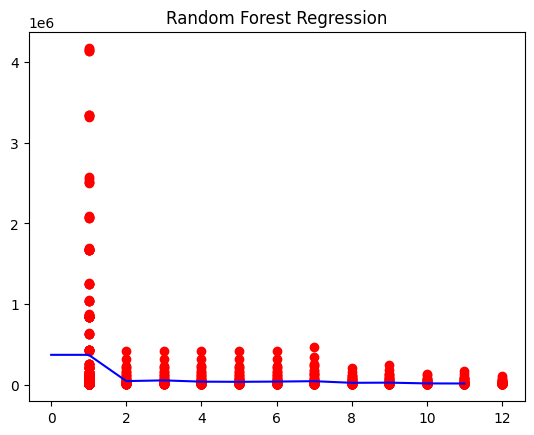

In [16]:
# Random Forest
#predictors = ['nodes', 'exploit', 'appl', 'load']
predictors = ['nodes']
overall_outcome = 'runtime'

# partition data
X = timing_df[predictors]
overall_y = timing_df[overall_outcome]
train_X, valid_X, train_y, valid_y = train_test_split(X, overall_y, test_size=0.4, random_state=1)

regressor = RandomForestRegressor(n_estimators = 10, random_state = 0)
regressor.fit(train_X, train_y)

X_grid = np.arange(0, 12, 1)
X_grid = X_grid.reshape((len(X_grid),1))
plt.scatter(X, overall_y, color = 'red')
plt.plot(X_grid, regressor.predict(X_grid), color = 'blue')
plt.title('Random Forest Regression')
plt.show()

### Exploit

/home/noah/.local/lib/python3.10/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


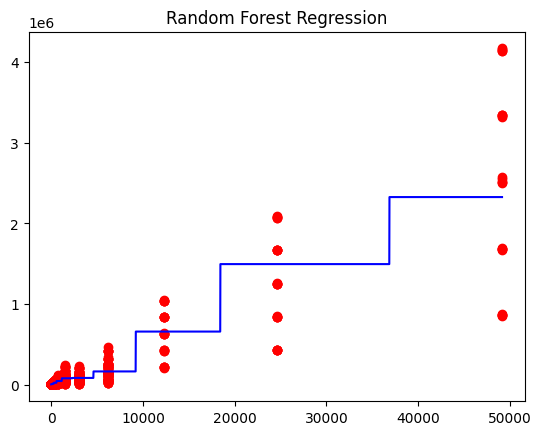

In [17]:
# Random Forest
#predictors = ['nodes', 'exploit', 'appl', 'load']
predictors = ['exploit']
overall_outcome = 'runtime'

# partition data
X = timing_df[predictors]
overall_y = timing_df[overall_outcome]
train_X, valid_X, train_y, valid_y = train_test_split(X, overall_y, test_size=0.4, random_state=1)

regressor = RandomForestRegressor(n_estimators = 10, random_state = 0)
regressor.fit(train_X, train_y)

X_grid = np.arange(0, 49152, 10)
X_grid = X_grid.reshape((len(X_grid),1))
plt.scatter(X, overall_y, color = 'red')
plt.plot(X_grid, regressor.predict(X_grid), color = 'blue')
plt.title('Random Forest Regression')
plt.show()

### Applicable

/home/noah/.local/lib/python3.10/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


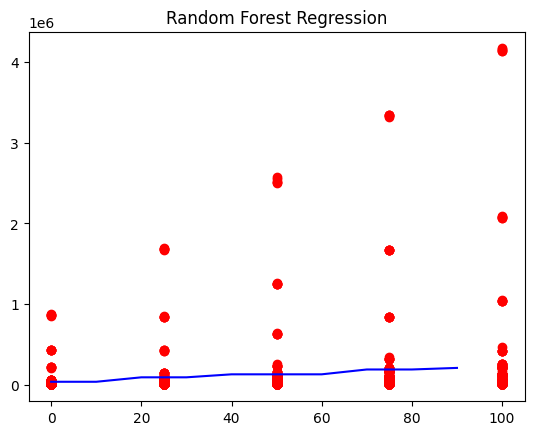

In [18]:
# Random Forest
#predictors = ['nodes', 'exploit', 'appl', 'load']
predictors = ['appl']
overall_outcome = 'runtime'

# partition data
X = timing_df[predictors]
overall_y = timing_df[overall_outcome]
train_X, valid_X, train_y, valid_y = train_test_split(X, overall_y, test_size=0.4, random_state=1)

regressor = RandomForestRegressor(n_estimators = 10, random_state = 0)
regressor.fit(train_X, train_y)

X_grid = np.arange(0, 100, 10)
X_grid = X_grid.reshape((len(X_grid),1))
plt.scatter(X, overall_y, color = 'red')
plt.plot(X_grid, regressor.predict(X_grid), color = 'blue')
plt.title('Random Forest Regression')
plt.show()

### Load

/home/noah/.local/lib/python3.10/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


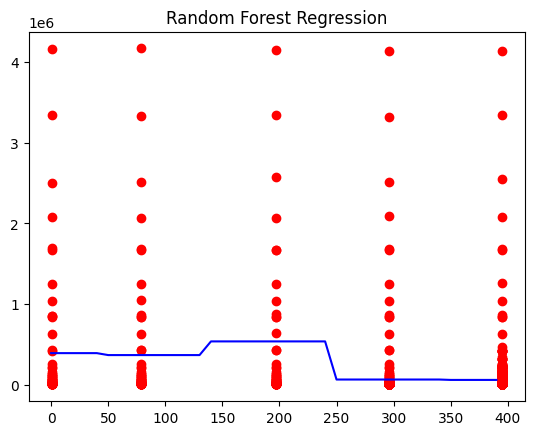

In [19]:
# Random Forest
#predictors = ['nodes', 'exploit', 'appl', 'load']
predictors = ['load']
overall_outcome = 'runtime'

# partition data
X = timing_df[predictors]
overall_y = timing_df[overall_outcome]
train_X, valid_X, train_y, valid_y = train_test_split(X, overall_y, test_size=0.4, random_state=1)

regressor = RandomForestRegressor(n_estimators = 10, random_state = 0)
regressor.fit(train_X, train_y)

X_grid = np.arange(0, 400, 10)
X_grid = X_grid.reshape((len(X_grid),1))
plt.scatter(X, overall_y, color = 'red')
plt.plot(X_grid, regressor.predict(X_grid), color = 'blue')
plt.title('Random Forest Regression')
plt.show()

## Gradient Boosting Classifier

The mean squared error (MSE) on test set: 359835092.9070


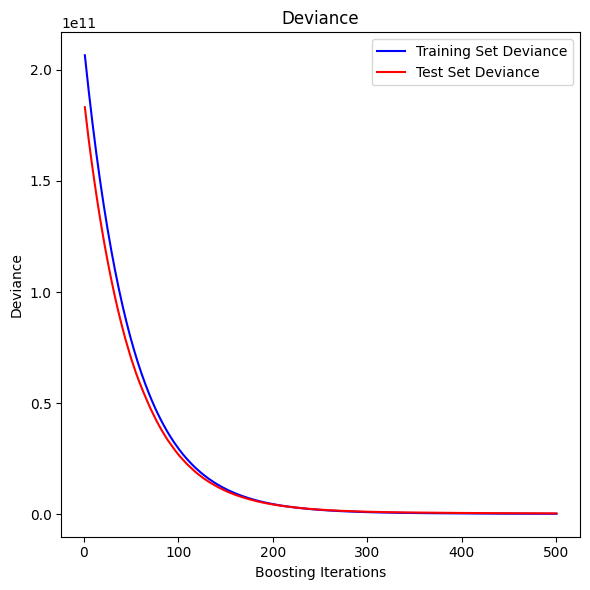

In [20]:
predictors = ['nodes', 'exploit', 'appl', 'load']
overall_outcome = 'runtime'

# partition data
X = timing_df[predictors]
overall_y = timing_df[overall_outcome]
train_X, valid_X, train_y, valid_y = train_test_split(X, overall_y, test_size=0.4, random_state=1)

params = {
    "n_estimators": 500,
    "max_depth": 4,
    "min_samples_split": 5,
    "learning_rate": 0.01,
    "loss": "squared_error",
}

reg = GradientBoostingRegressor(**params)
reg.fit(train_X, train_y)

mse = mean_squared_error(valid_y, reg.predict(valid_X))
print("The mean squared error (MSE) on test set: {:.4f}".format(mse))


test_score = np.zeros((params["n_estimators"],), dtype=np.float64)
for i, y_pred in enumerate(reg.staged_predict(valid_X)):
    test_score[i] = mean_squared_error(valid_y, y_pred)

fig = plt.figure(figsize=(6, 6))
plt.subplot(1, 1, 1)
plt.title("Deviance")
plt.plot(
    np.arange(params["n_estimators"]) + 1,
    reg.train_score_,
    "b-",
    label="Training Set Deviance",
)
plt.plot(
    np.arange(params["n_estimators"]) + 1, test_score, "r-", label="Test Set Deviance"
)
plt.legend(loc="upper right")
plt.xlabel("Boosting Iterations")
plt.ylabel("Deviance")
fig.tight_layout()
plt.show()

## Polynomial Regressionwhat is considered high VIF

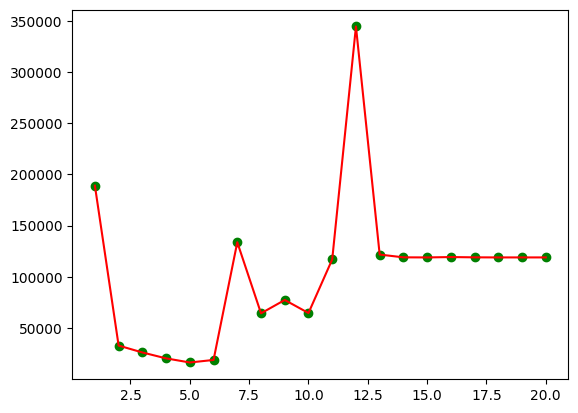

In [44]:
predictors = ['nodes', 'exploit', 'appl', 'load']
overall_outcome = 'runtime'

# partition data
X = timing_df[predictors]
overall_y = timing_df[overall_outcome]
train_X, valid_X, train_y, valid_y = train_test_split(X, overall_y, test_size=0.4, random_state=1)

plt_mean_squared_error = []
deg_range = range(1,21)
for degree in deg_range:
    poly = PolynomialFeatures(degree = degree)
    X_poly = poly.fit_transform(train_X)
    poly.fit(X_poly, train_y)

    regression_model = LinearRegression()
    regression_model.fit(X_poly, train_y)
    y_pred = regression_model.predict(X_poly)
    plt_mean_squared_error.append(mean_squared_error(train_y, y_pred, squared=False))


plt.scatter(deg_range,plt_mean_squared_error, color="green")
plt.plot(deg_range,plt_mean_squared_error, color="red")

## SVR

In [46]:
# SVR
predictors = ['nodes', 'exploit', 'appl', 'load']
overall_outcome = 'runtime'

# partition data
X = timing_df[predictors]
overall_y = timing_df[overall_outcome]
train_X, valid_X, train_y, valid_y = train_test_split(X, overall_y, test_size=0.4, random_state=1)

param_grid = {'C': [0.1,1, 10, 100, 1000], 'gamma': [1,0.1,0.01,0.001,0.0001], 'kernel': ['rbf']}
grid = GridSearchCV(SVR(),param_grid,refit=True,verbose=0)
grid.fit(train_X,train_y)

grid_predictions = grid.predict(valid_X)

mean_squared_error(valid_y, grid_predictions, squared=False)

439524.8341302504